In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
from scipy.stats import iqr
from scipy.stats import boxcox
%matplotlib inline


In [2]:
path = 'table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls'
data = pd.read_excel(path, header=4)
df = pd.DataFrame(data)
df.columns = df.columns.str.replace('\n',' ', regex=True)
df = df[:-3]
df = df.drop('Rape (revised definition)1', axis=1)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
City                                    348 non-null object
Population                              348 non-null float64
Violent crime                           348 non-null float64
Murder and nonnegligent manslaughter    348 non-null float64
Rape (legacy definition)2               348 non-null float64
Robbery                                 348 non-null float64
Aggravated assault                      348 non-null float64
Property crime                          348 non-null float64
Burglary                                348 non-null float64
Larceny- theft                          348 non-null float64
Motor vehicle theft                     348 non-null float64
Arson3                                  187 non-null float64
dtypes: float64(11), object(1)
memory usage: 31.3+ KB
None
                       City  Population  Violent crime  \
0             Adams Village      1861.0        

In [3]:
# propertycrime = alpha + Population + Populations**2 + Murder + Robbery

# create the property crime dataframe
property_crime_df = pd.DataFrame()

# add the population and population squared to the dataset
property_crime_df['Population'] = df['Population']
property_crime_df['Population Squared'] = df['Population']**2

# For the murder and robbery columns - set up a binary coding such that
# 0 = 0 and >0 = 1
property_crime_df['Murder'] = np.where(df['Murder and nonnegligent manslaughter'] > 0, 1, 0)
property_crime_df['Robbery'] = np.where(df['Robbery'] > 0, 1, 0)

# Add dependent variable
property_crime_df['Property crime'] = df['Property crime']

print(property_crime_df.head())

#for col in property_crime_df.columns:
   # print(col)
    #plt.plot(property_crime_df[col])
   # plt.show()

# there is an obvious outlier in the population
#print(df.iloc[property_crime_df.Population.idxmax()])

# The outlier here is the population of NYC which is accurate 8.3million in 2013
# let's look at the next highest population

#print(df.Population.nlargest(2).tolist()[1])

#print(df.iloc[35])

   Population  Population Squared  Murder  Robbery  Property crime
0      1861.0        3.463321e+06       0        0            12.0
1      2577.0        6.640929e+06       0        0            24.0
2      2846.0        8.099716e+06       0        0            16.0
3     97956.0        9.595378e+09       1        1          4090.0
4      6388.0        4.080654e+07       0        1           223.0


So we do have an outlier in the population that we will likely have to deal with.  I am thinking I will replace that value with the next highest population which is Buffalo.

In [4]:
ind = df.Population.idxmax()
repval = df.Population.nlargest(2).tolist()[1]

print(property_crime_df.iloc[216])

ind1 = df['Property crime'].idxmax()
repval1 = df['Property crime'].nlargest(2).tolist()
#print(repval1)

dropped_property_crime_df = property_crime_df.copy()
dropped_property_crime_df.loc[ind, 'Population'] = repval
dropped_property_crime_df.loc[ind1, 'Property crime'] = repval1[1]
print(dropped_property_crime_df.iloc[216])
print('')
print(property_crime_df.iloc[216])
print('')
print(df.iloc[216])

Population            8.396126e+06
Population Squared    7.049493e+13
Murder                1.000000e+00
Robbery               1.000000e+00
Property crime        1.419710e+05
Name: 216, dtype: float64
Population            2.587890e+05
Population Squared    7.049493e+13
Murder                1.000000e+00
Robbery               1.000000e+00
Property crime        1.249100e+04
Name: 216, dtype: float64

Population            8.396126e+06
Population Squared    7.049493e+13
Murder                1.000000e+00
Robbery               1.000000e+00
Property crime        1.419710e+05
Name: 216, dtype: float64

City                                       New York
Population                              8.39613e+06
Violent crime                                 52384
Murder and nonnegligent manslaughter            335
Rape (legacy definition)2                      1112
Robbery                                       19170
Aggravated assault                            31767
Property crime                 

# Linear regression function - sklearn

In [5]:
def linregfunc(X, Y):
    
    regr = linear_model.LinearRegression()
    
    regr.fit(X, Y)
    print('\nCoefficients: \n', regr.coef_)
    print('\nIntercept: \n', regr.intercept_)
    print('\nR-squared:')
    print(regr.score(X, Y))
    
    # Extract predicted values.
    predicted = regr.predict(X).ravel()
    actual = Y

    # Calculate the error, also called the residual.
    residual = actual - predicted
    
    # Plot residuals to see the multivariate normality
    plt.hist(residual, edgecolor='k')
    plt.title('Residual counts')
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.show()
    
    # Plot the predicted values vs residuals to check homoscedasticity
    plt.scatter(predicted, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    plt.show()
    
    correlation_matrix = X.corr()
    display(correlation_matrix)

## Attempt 1: features from drill


Coefficients: 
 [ 3.46570268e-02 -2.11108019e-09  1.51866535e+01 -9.62774363e+01]

Intercept: 
 -109.57533562257231

R-squared:
0.9961247104988709


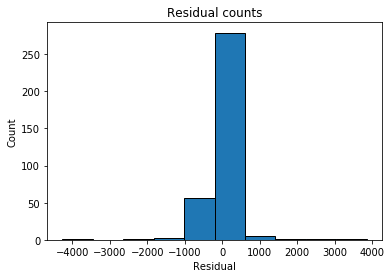

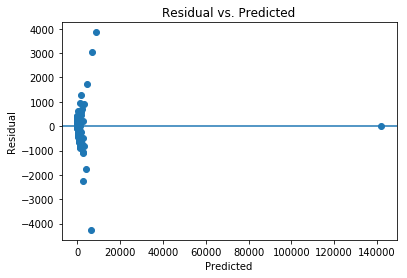

,Population,Population Squared,Murder,Robbery
Population,1.000000,0.998264,0.162309,0.064371
Population Squared,0.998264,1.000000,0.133067,0.043983
Murder,0.162309,0.133067,1.000000,0.313271
Robbery,0.064371,0.043983,0.313271,1.000000


In [6]:
# regression using the features set up in the example
X = property_crime_df.drop('Property crime', axis=1)
Y = property_crime_df['Property crime']
linregfunc(X, Y)

There is a lot of correlation between the two population variables (as expected).  The distribution of the residuals is not very normal likely due to to outliers, which can be seen in the plot below the histogram.  We have heteroscedasticity that needs to be addressed.

## Attempt 2: drop NYC and replace with next largest 


Coefficients: 
 [ 3.43731100e-02  5.37084652e-11  1.44804057e+01 -9.41315054e+01]

Intercept: 
 -108.36742636281974

R-squared:
0.8487095050843759


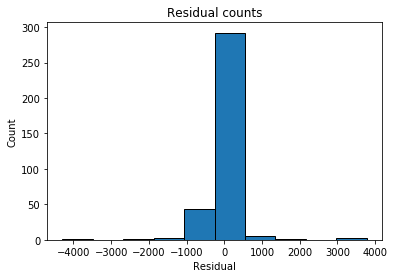

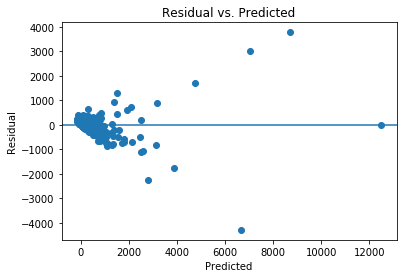

,Population,Population Squared,Murder,Robbery
Population,1.000000,0.434816,0.506480,0.328960
Population Squared,0.434816,1.000000,0.133067,0.043983
Murder,0.506480,0.133067,1.000000,0.313271
Robbery,0.328960,0.043983,0.313271,1.000000


In [7]:
# now with population outlier dropped
X_1 = dropped_property_crime_df.drop('Property crime', axis=1)
Y_1 = dropped_property_crime_df['Property crime']
linregfunc(X_1, Y_1)

The correlation between the two population variables went down, but we still have an issue with the heteroscedasticity.

## Attempt 3: drop the population / population squared variable


Coefficients: 
 [1.99256120e-09 1.18406016e+03 3.00052598e+02]

Intercept: 
 40.08610470544852

R-squared:
0.9859871204030131


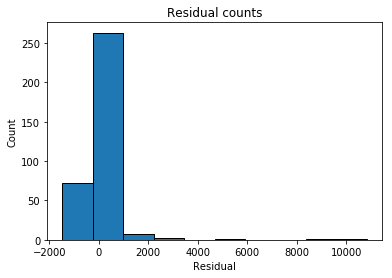

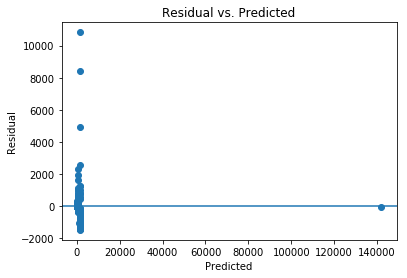

,Population Squared,Murder,Robbery
Population Squared,1.000000,0.133067,0.043983
Murder,0.133067,1.000000,0.313271
Robbery,0.043983,0.313271,1.000000


In [8]:
# population and population squared have too much correlation - drop population
X1 = property_crime_df.drop(['Population', 'Property crime'], axis=1)
linregfunc(X1, Y)


Coefficients: 
 [1.68728222e-02 6.07383740e+02 1.06994709e+02]

Intercept: 
 -32.72226823930714

R-squared:
0.99344854357257


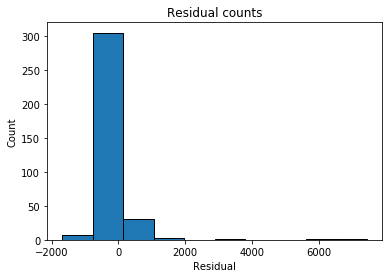

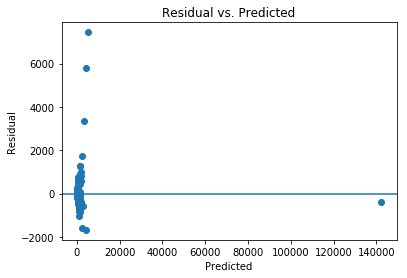

,Population,Murder,Robbery
Population,1.000000,0.162309,0.064371
Murder,0.162309,1.000000,0.313271
Robbery,0.064371,0.313271,1.000000


In [9]:
# population and population squared have too much correlation - drop population squared
X2 = property_crime_df.drop(['Population Squared', 'Property crime'], axis=1)
linregfunc(X2, Y)

Both models R^2 value is extremely high, correlation is low, but the issue with the heteroscedasticity is still there.

## Attempt 4: Start over with all variables in the dataset


Coefficients: 
 [ 0.00000000e+00  1.82076576e-14  5.84410992e-14  8.62591248e-15
 -2.58126853e-14 -2.22044605e-14  1.00000000e+00  1.00000000e+00
  1.00000000e+00]

Intercept: 
 1.2505552149377763e-12

R-squared:
1.0


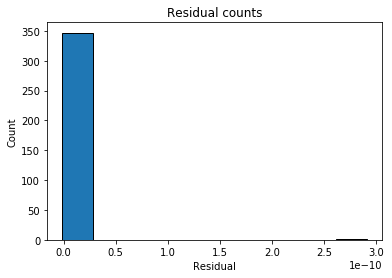

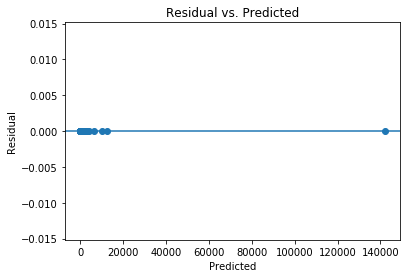

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Burglary,Larceny- theft,Motor vehicle theft
Population,1.000000,0.998854,0.986758,0.990839,0.998469,0.999134,0.970578,0.997946,0.992421
Violent crime,0.998854,1.000000,0.992098,0.994985,0.999923,0.999942,0.978150,0.998762,0.996271
Murder and nonnegligent manslaughter,0.986758,0.992098,1.000000,0.997746,0.993104,0.990843,0.993733,0.993175,0.997992
Rape (legacy definition)2,0.990839,0.994985,0.997746,1.000000,0.995438,0.994140,0.992442,0.996260,0.998764
Robbery,0.998469,0.999923,0.993104,0.995438,1.000000,0.999742,0.979525,0.998735,0.996927
Aggravated assault,0.999134,0.999942,0.990843,0.994140,0.999742,1.000000,0.976288,0.998561,0.995403
Burglary,0.970578,0.978150,0.993733,0.992442,0.979525,0.976288,1.000000,0.982700,0.991464
Larceny- theft,0.997946,0.998762,0.993175,0.996260,0.998735,0.998561,0.982700,1.000000,0.996878
Motor vehicle theft,0.992421,0.996271,0.997992,0.998764,0.996927,0.995403,0.991464,0.996878,1.000000


In [10]:
# let's try with all of the complete numeric variables in the dataset 
# drop city and arson3

X3 = df.drop(['City', 'Arson3', 'Property crime'], axis=1)
linregfunc(X3, Y)

We can clearly see that our coefficients for the first 6 variables is essentially 0, while the last 3 are 1.  Let's drop the first 6 variables due to how little they seem to impact the model.

## Attempt 5: Using most relevant variables


Coefficients: 
 [1. 1. 1.]

Intercept: 
 1.4779288903810084e-12

R-squared:
1.0


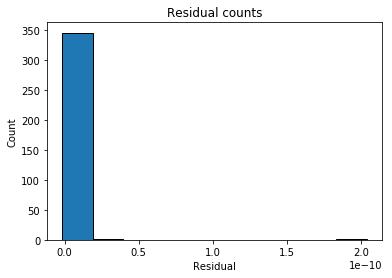

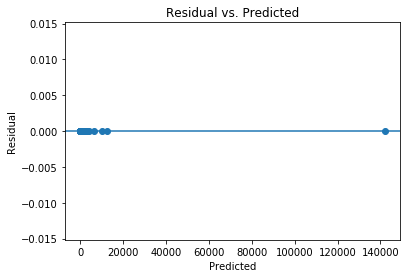

,Burglary,Larceny- theft,Motor vehicle theft
Burglary,1.000000,0.982700,0.991464
Larceny- theft,0.982700,1.000000,0.996878
Motor vehicle theft,0.991464,0.996878,1.000000


In [11]:
X4 = df[['Burglary', 'Larceny- theft', 'Motor vehicle theft']]
linregfunc(X4, Y)

The heteroscedasticity issue is resolved with these 3 variables, but there is a high level of correlation.

### Check for linearity

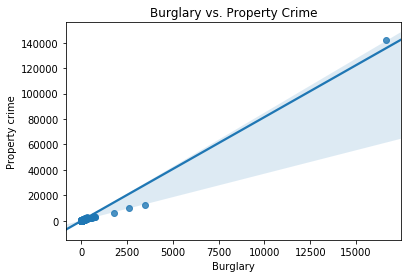

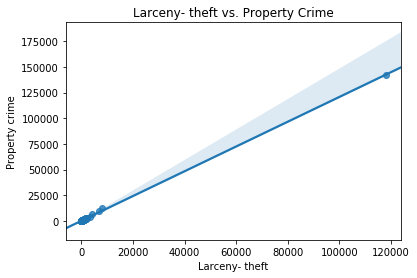

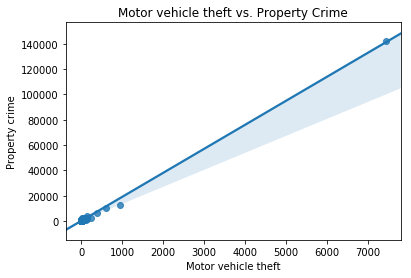

In [12]:
for x in X4.columns:
    sns.regplot(x=df[x], y=df['Property crime'])
    plt.title(str(x)+' vs. Property Crime')
    plt.show()

In [13]:
def get_residuals(X, Y):
    '''Get the largest residuals'''
    regr = linear_model.LinearRegression()
    
    regr.fit(X, Y)
       
    # Extract predicted values.
    predicted = regr.predict(X).ravel()
    actual = Y

    # Calculate the error, also called the residual.
    residual = actual - predicted
    
    # Create dataframe to view predicted, actual, and residuals
    resdf = pd.DataFrame([predicted, actual, residual]).T
    resdf.columns = ['Predicted', 'Actual', 'Residual']
    resdf = resdf.sort_values(by='Residual')
    
    return resdf.head(), resdf.tail()

In [14]:
get_residuals(X4, Y)

(        Predicted  Actual      Residual
 13   5.000000e+00     5.0 -1.479705e-12
 186  1.477929e-12     0.0 -1.477929e-12
 208  1.477929e-12     0.0 -1.477929e-12
 256  1.477929e-12     0.0 -1.477929e-12
 287  1.477929e-12     0.0 -1.477929e-12,
      Predicted    Actual      Residual
 218     2807.0    2807.0  6.366463e-12
 310     6473.0    6473.0  1.546141e-11
 272    10051.0   10051.0  2.364686e-11
 35     12491.0   12491.0  2.910383e-11
 216   141971.0  141971.0  2.037268e-10)

We have linear relationships between our outcome variable and the 3 feature variables, the error (residual) from the model is essentially 0 giving us the homoscedasticity - there one residual that is arguably an outlier associated with the city of NY. We do have a lot of correlation between these 3 features but since our goal is to predict the property crime, covering the variance is more important than being able to determining the strength of the features individually.



### Dropping the NYC outlier completely


Coefficients: 
 [1. 1. 1.]

Intercept: 
 2.2737367544323206e-13

R-squared:
1.0


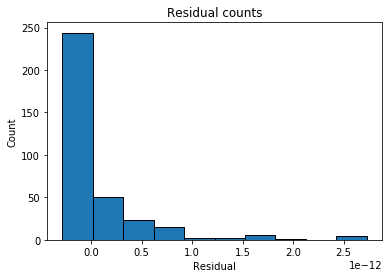

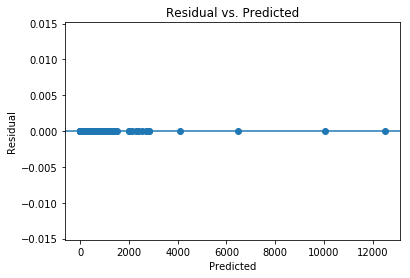

,Burglary,Larceny- theft,Motor vehicle theft
Burglary,1.000000,0.949552,0.976357
Larceny- theft,0.949552,1.000000,0.916178
Motor vehicle theft,0.976357,0.916178,1.000000


In [15]:
# let's see what happens if we drop NYC

X5 = X4.drop(index=216)
Y1 = Y.drop(index=216)
linregfunc(X5, Y1)

### Recheck for linearity

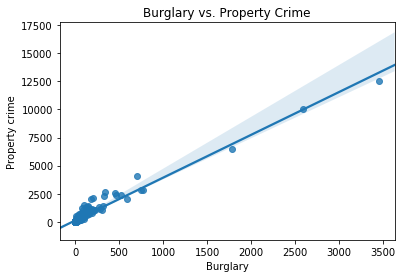

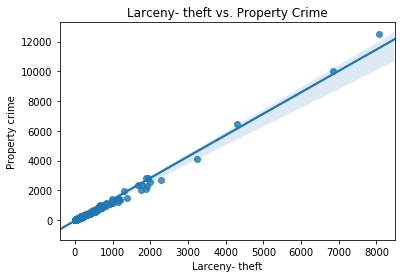

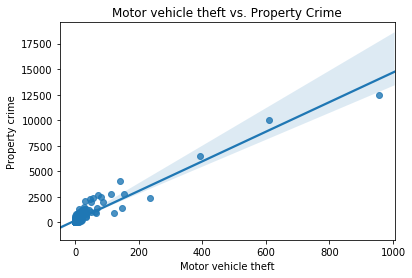

In [16]:
for x in X5.columns:
    sns.regplot(x=X5[x], y=Y1)
    plt.title(str(x)+' vs. Property Crime')
    plt.show()

In [17]:
get_residuals(X5, Y1)

(     Predicted  Actual      Residual
 199      276.0   276.0 -2.842171e-13
 99       162.0   162.0 -2.557954e-13
 263       33.0    33.0 -2.415845e-13
 230       54.0    54.0 -2.415845e-13
 104       50.0    50.0 -2.415845e-13,     Predicted  Actual      Residual
 57     1515.0  1515.0  2.046363e-12
 62     1990.0  1990.0  2.501110e-12
 3      4090.0  4090.0  2.728484e-12
 7      2118.0  2118.0  2.728484e-12
 53     2689.0  2689.0  2.728484e-12)

# Re-create the model with StatsModel

### Using only the 3 variables from before

In [18]:
linform = "Q('Property crime') ~ Burglary+Q('Larceny- theft')+Q('Motor vehicle theft')"
lm = smf.ols(formula=linform, data=data).fit()
print(lm.summary())
print(data.columns)

                             OLS Regression Results                            
Dep. Variable:     Q('Property crime')   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                  1.000
Method:                  Least Squares   F-statistic:                 1.524e+33
Date:                 Sun, 14 Oct 2018   Prob (F-statistic):               0.00
Time:                         14:35:36   Log-Likelihood:                 8864.0
No. Observations:                  348   AIC:                        -1.772e+04
Df Residuals:                      344   BIC:                        -1.770e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept     

### Using the full model to check p-values for all the variables

In [19]:
linform = "Q('Property crime') ~ Population + Q('Violent crime')+Q('Murder and nonnegligent manslaughter')+Q('Rape (legacy definition)2')+Robbery+Q('Aggravated assault')+Burglary+Q('Larceny- theft')+Q('Motor vehicle theft')"
lm = smf.ols(formula=linform, data=data).fit()
print(lm.summary())

                             OLS Regression Results                            
Dep. Variable:     Q('Property crime')   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                  1.000
Method:                  Least Squares   F-statistic:                 1.330e+27
Date:                 Sun, 14 Oct 2018   Prob (F-statistic):               0.00
Time:                         14:35:36   Log-Likelihood:                 6609.5
No. Observations:                  348   AIC:                        -1.320e+04
Df Residuals:                      339   BIC:                        -1.317e+04
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

# Validate model

### Holdout 20% 

In [20]:
# Split the dataset 80/20
X_train, X_test, y_train, y_test = train_test_split(X4, Y, test_size=0.2)

# Instantiate the model
regr = linear_model.LinearRegression()

# Fit the data
regr.fit(X_train, y_train)

# Coefficients and Intercept
print('Coefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)

# R squared
print('\nR-squared:')
print(regr.score(X_test, y_test))

Coefficients: 
 [1. 1. 1.]

Intercept: 
 4.547473508864641e-13

R-squared:
1.0


### Cross Validation

In [21]:
cross_val_score(regr, X4, Y, cv=10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Load in new data to set how well model performs with new dataset

In [22]:
def loaddata(stpath, name):
    statepath = stpath
    st = pd.read_excel(statepath, header=4)
    name = pd.DataFrame(st)
    name.columns = name.columns.str.replace('\n',' ', regex=True)
    name = name[:-3]
    name = name.drop('Rape (revised definition)1', axis=1)
    return name
def testreg(df):
    X = df[['Burglary', 'Larceny- theft', 'Motor vehicle theft']]
    Y = df['Property crime']
    city = df['City']
    linregfunc(X, Y)

### Georgia


Coefficients: 
 [1. 1. 1.]

Intercept: 
 -1.1368683772161603e-13

R-squared:
1.0


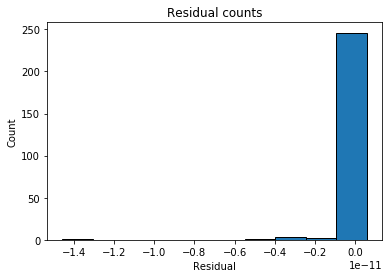

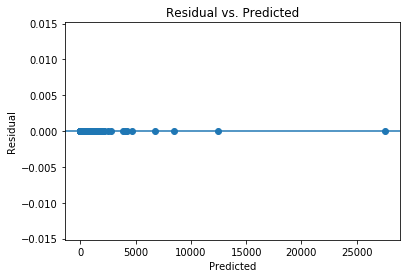

,Burglary,Larceny- theft,Motor vehicle theft
Burglary,1.000000,0.984207,0.921676
Larceny- theft,0.984207,1.000000,0.932858
Motor vehicle theft,0.921676,0.932858,1.000000


In [89]:
GA = loaddata('table_8_offenses_known_to_law_enforcement_georgia_by_city_2013.xls', 'GA')

testreg(GA)

### Colorado

                     City  Population  Violent crime  \
0                  Arvada    110792.0          163.0   
1                   Aspen      6685.0           14.0   
2                    Ault      1565.0            0.0   
3                  Aurora    343484.0         1436.0   
4                    Avon      6336.0            9.0   
5                  Basalt      3818.0            2.0   
6                Berthoud      5316.0            3.0   
7              Black Hawk       119.0            6.0   
8              Blue River       854.0            1.0   
9                 Boulder    102828.0          218.0   
10                Bow Mar       900.0            0.0   
11           Breckenridge      4568.0           22.0   
12             Broomfield     59424.0           33.0   
13                  Brush      5529.0            6.0   
14            Buena Vista      2678.0            0.0   
15             Burlington      3939.0           11.0   
16                  Campo       109.0           

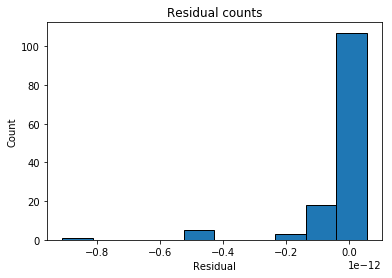

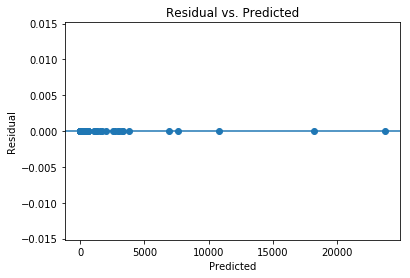

,Burglary,Larceny- theft,Motor vehicle theft
Burglary,1.000000,0.981458,0.971957
Larceny- theft,0.981458,1.000000,0.953479
Motor vehicle theft,0.971957,0.953479,1.000000


In [90]:
CO = loaddata('table_8_offenses_known_to_law_enforcement_colorado_by_city_2013.xls', 'CO')
print(CO)
testreg(CO)

 This model seems to work perfectly, which does not seem right.
 
 We know we have a linear relationship between our outcome variable and the features.  Let's start back over and look at the distribution for our dependent variable.

# Check the distribution for our dependent variable

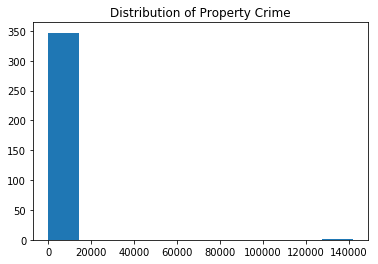

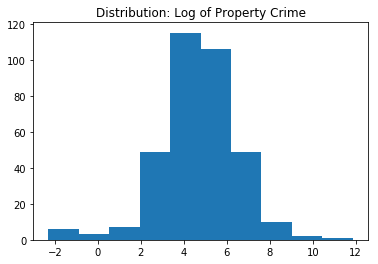

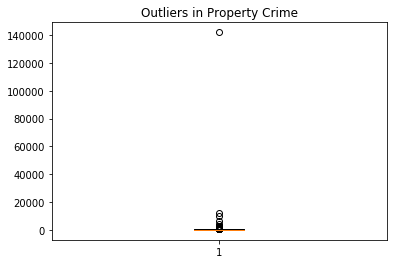

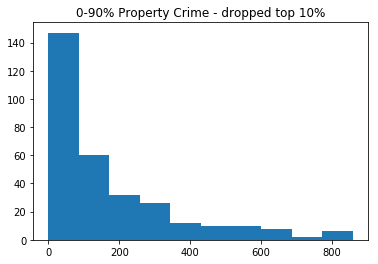

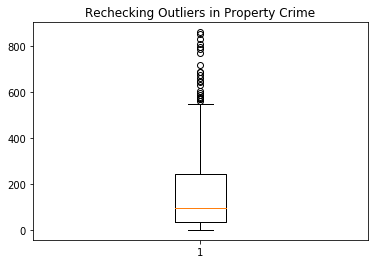

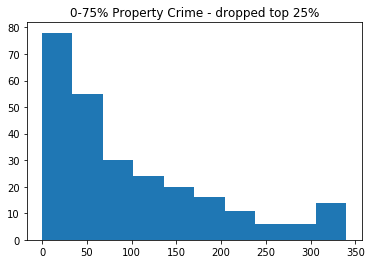

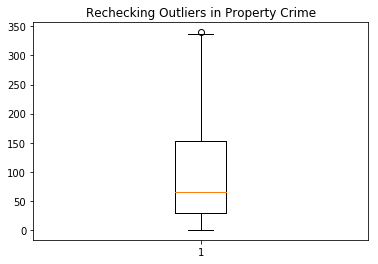

In [25]:
# Histogram of property crime for NY
plt.hist(df['Property crime'])
plt.title('Distribution of Property Crime')
plt.show()

plt.hist(np.log(df['Property crime']+.1)) # tried 1, .0001, .01, and .1 - .1 yielded most normal
plt.title('Distribution: Log of Property Crime')
plt.show()

# outlier in NYC property crime numbers

plt.boxplot(df['Property crime'])
plt.title('Outliers in Property Crime')
plt.show()

threshold90 = iqr(df['Property crime'], rng=(0,90))


new_df = df['Property crime'][df['Property crime'] < threshold90]
plt.hist(new_df)
plt.title('0-90% Property Crime - dropped top 10%')
plt.show()

plt.boxplot(new_df)
plt.title('Rechecking Outliers in Property Crime')
plt.show()

threshold75 = iqr(df['Property crime'], rng=(0,75))


new_df1 = df['Property crime'][df['Property crime'] < threshold75]
plt.hist(new_df1)
plt.title('0-75% Property Crime - dropped top 25%')
plt.show()

plt.boxplot(new_df1)
plt.title('Rechecking Outliers in Property Crime')
plt.show()

Did not have a normal distribution for the outcome variable.  Need to work on that.

## Boxcox transformation for dependent variable

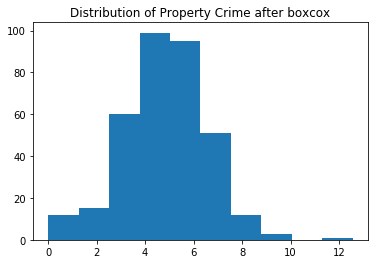

In [26]:
# Try boxcox transform on the full variable - need strictly positive data!!
#pos_prop_crime = df['Property crime'][df['Property crime'] > 0] - we lose data with this 

# Let's try a shift by adding 1 to the data set so they are all positive values
pos_prop_crime = df['Property crime']+1

# boxcox transform
bc_prop_crime, lam = boxcox(pos_prop_crime)

plt.hist(bc_prop_crime)
plt.title('Distribution of Property Crime after boxcox')
plt.show()

## Rerunning model with top 3 variables against transformed dependent variable


Coefficients: 
 [ 0.00968367  0.0014079  -0.04278976]

Intercept: 
 4.3365190785523335

R-squared:
0.3928930735019809


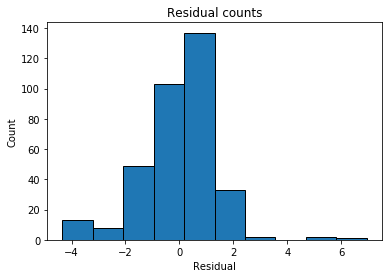

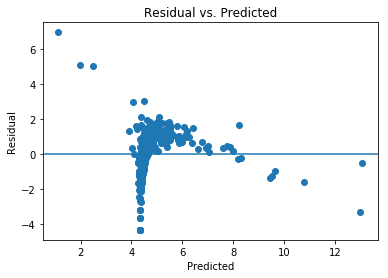

,Burglary,Larceny- theft,Motor vehicle theft
Burglary,1.000000,0.982700,0.991464
Larceny- theft,0.982700,1.000000,0.996878
Motor vehicle theft,0.991464,0.996878,1.000000



Coefficients: 
 [ 0.00948655  0.00140092 -0.0423104 ]

Intercept: 
 4.158703380952334

R-squared:
0.33667167933617825


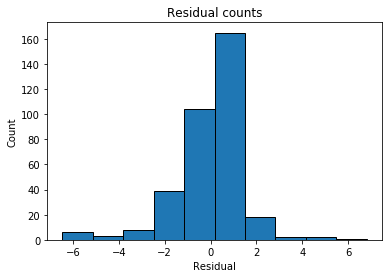

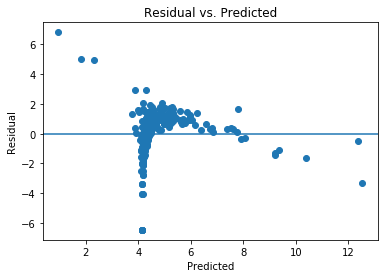

,Burglary,Larceny- theft,Motor vehicle theft
Burglary,1.000000,0.982700,0.991464
Larceny- theft,0.982700,1.000000,0.996878
Motor vehicle theft,0.991464,0.996878,1.000000


In [27]:
linregfunc(X4, bc_prop_crime) # boxcox transform

linregfunc(X4, np.log(df['Property crime']+.1)) # log transform

## Recheck linearity

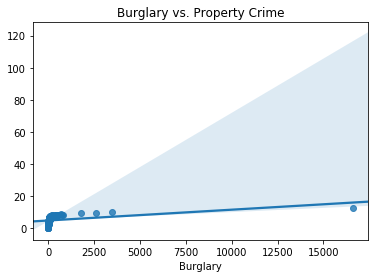

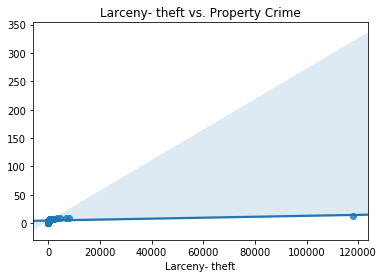

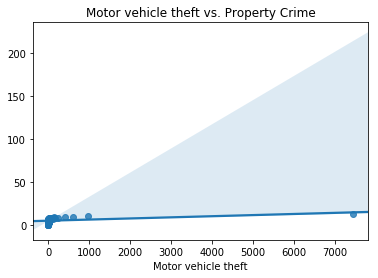

In [28]:
for x in X4.columns:
    sns.regplot(x=X4[x], y=bc_prop_crime)
    plt.title(str(x)+' vs. Property Crime')
    plt.show()

Let's try retransforming property crime using all the data up to Q3 and toss the rest as outliers

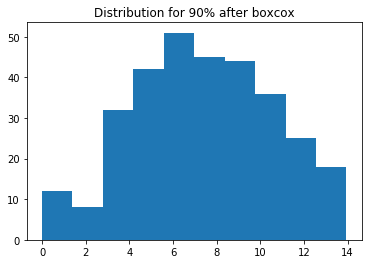

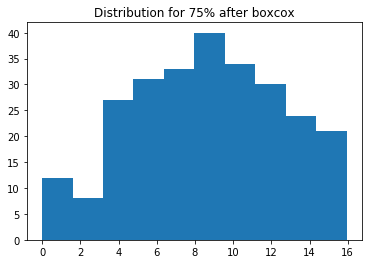

In [29]:
pos_new_df = new_df + 1
bc_prop_crime90, lam = boxcox(pos_new_df)

plt.hist(bc_prop_crime90)
plt.title('Distribution for 90% after boxcox')
plt.show()

pos_new_df1 = new_df1 + 1
bc_prop_crime75, lam = boxcox(pos_new_df1)

plt.hist(bc_prop_crime75)
plt.title('Distribution for 75% after boxcox')
plt.show()

## Rerun model with all variables against boxcox and log(x+.1)


Coefficients: 
 [ 3.33783538e-05 -3.33375939e-02 -1.33262739e-01  5.41271037e-02
  1.98911541e-02  2.59068873e-02  6.42095231e-03  1.28302569e-03
 -3.93516624e-04]

Intercept: 
 3.9682460311047363

R-squared:
0.5401351096200255


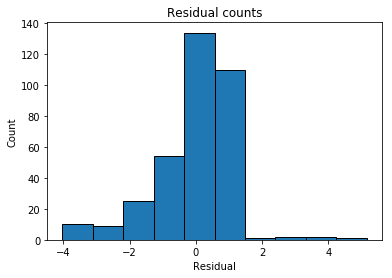

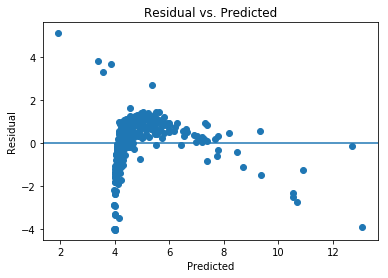

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Burglary,Larceny- theft,Motor vehicle theft
Population,1.000000,0.998854,0.986758,0.990839,0.998469,0.999134,0.970578,0.997946,0.992421
Violent crime,0.998854,1.000000,0.992098,0.994985,0.999923,0.999942,0.978150,0.998762,0.996271
Murder and nonnegligent manslaughter,0.986758,0.992098,1.000000,0.997746,0.993104,0.990843,0.993733,0.993175,0.997992
Rape (legacy definition)2,0.990839,0.994985,0.997746,1.000000,0.995438,0.994140,0.992442,0.996260,0.998764
Robbery,0.998469,0.999923,0.993104,0.995438,1.000000,0.999742,0.979525,0.998735,0.996927
Aggravated assault,0.999134,0.999942,0.990843,0.994140,0.999742,1.000000,0.976288,0.998561,0.995403
Burglary,0.970578,0.978150,0.993733,0.992442,0.979525,0.976288,1.000000,0.982700,0.991464
Larceny- theft,0.997946,0.998762,0.993175,0.996260,0.998735,0.998561,0.982700,1.000000,0.996878
Motor vehicle theft,0.992421,0.996271,0.997992,0.998764,0.996927,0.995403,0.991464,0.996878,1.000000



Coefficients: 
 [ 3.43445566e-05 -3.25265559e-02 -1.30271573e-01  5.35118031e-02
  1.91083841e-02  2.51248297e-02  6.45713596e-03  1.20354024e-03
 -7.72713975e-04]

Intercept: 
 3.78815691081747

R-squared:
0.46939901553101954


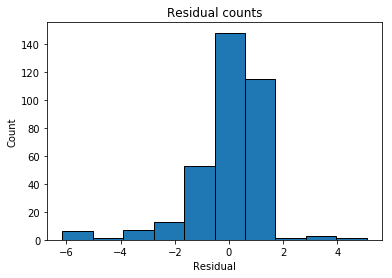

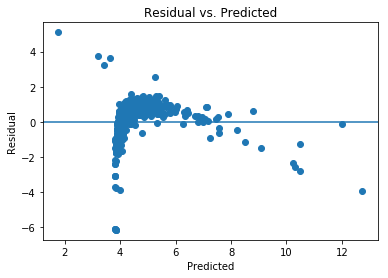

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Burglary,Larceny- theft,Motor vehicle theft
Population,1.000000,0.998854,0.986758,0.990839,0.998469,0.999134,0.970578,0.997946,0.992421
Violent crime,0.998854,1.000000,0.992098,0.994985,0.999923,0.999942,0.978150,0.998762,0.996271
Murder and nonnegligent manslaughter,0.986758,0.992098,1.000000,0.997746,0.993104,0.990843,0.993733,0.993175,0.997992
Rape (legacy definition)2,0.990839,0.994985,0.997746,1.000000,0.995438,0.994140,0.992442,0.996260,0.998764
Robbery,0.998469,0.999923,0.993104,0.995438,1.000000,0.999742,0.979525,0.998735,0.996927
Aggravated assault,0.999134,0.999942,0.990843,0.994140,0.999742,1.000000,0.976288,0.998561,0.995403
Burglary,0.970578,0.978150,0.993733,0.992442,0.979525,0.976288,1.000000,0.982700,0.991464
Larceny- theft,0.997946,0.998762,0.993175,0.996260,0.998735,0.998561,0.982700,1.000000,0.996878
Motor vehicle theft,0.992421,0.996271,0.997992,0.998764,0.996927,0.995403,0.991464,0.996878,1.000000


In [30]:
linregfunc(X3, bc_prop_crime)
linregfunc(X3, np.log(df['Property crime']+0.1))

## Check for linearity with each of the independent variables

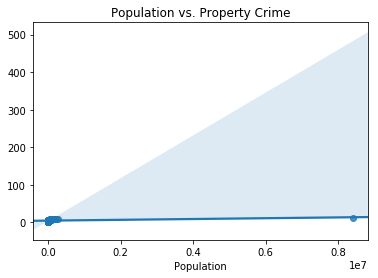

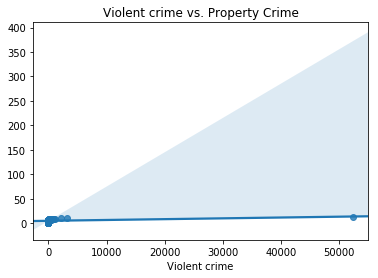

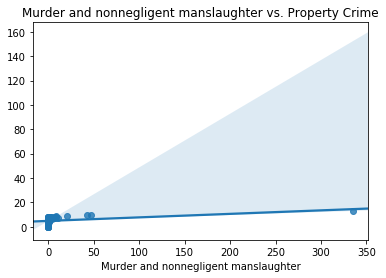

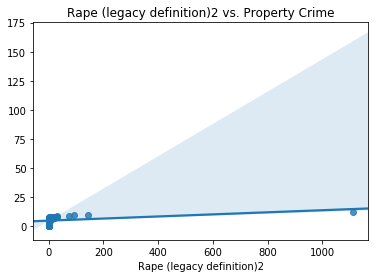

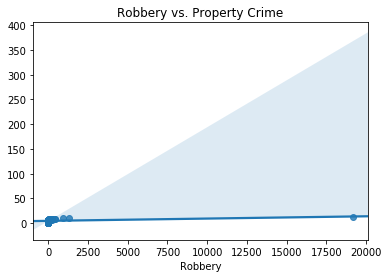

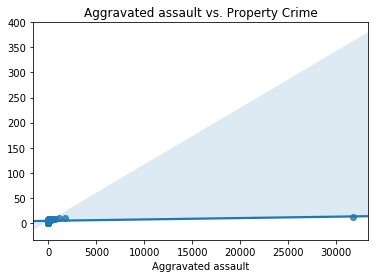

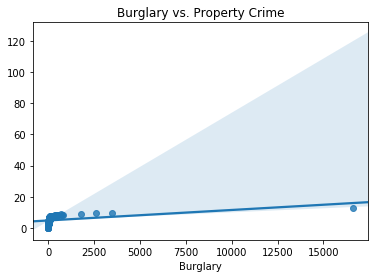

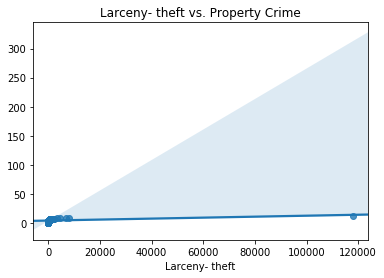

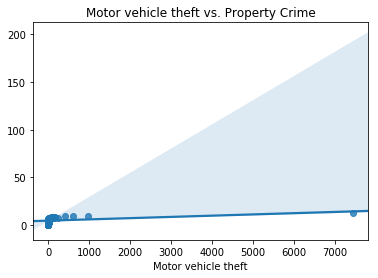

In [31]:
for x in X3.columns:
    sns.regplot(x=X3[x], y=bc_prop_crime)
    plt.title(str(x)+' vs. Property Crime')
    plt.show()

## Rerun the original features against the boxcox transform


Coefficients: 
 [ 2.71043712e-05 -3.12888653e-12  5.12101789e-01  1.78359713e+00]

Intercept: 
 3.26439898795096

R-squared:
0.6852690426684189


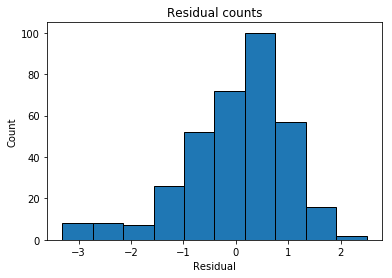

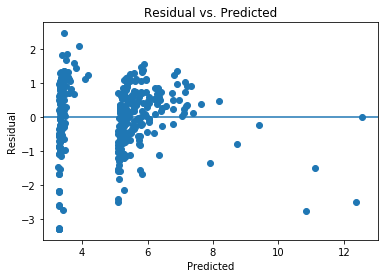

,Population,Population Squared,Murder,Robbery
Population,1.000000,0.998264,0.162309,0.064371
Population Squared,0.998264,1.000000,0.133067,0.043983
Murder,0.162309,0.133067,1.000000,0.313271
Robbery,0.064371,0.043983,0.313271,1.000000


In [32]:
linregfunc(X, bc_prop_crime)


Coefficients: 
 [8.04660749e-14 1.42624776e+00 2.09355668e+00]

Intercept: 
 3.3814453592877918

R-squared:
0.5690347404583642


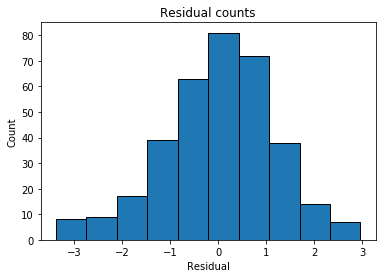

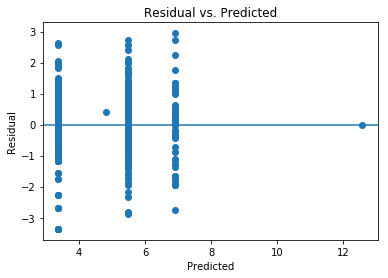

,Population Squared,Murder,Robbery
Population Squared,1.000000,0.133067,0.043983
Murder,0.133067,1.000000,0.313271
Robbery,0.043983,0.313271,1.000000


In [33]:
linregfunc(X.drop('Population', axis=1), bc_prop_crime)


Coefficients: 
 [7.45941759e-07 1.38981240e+00 2.08487203e+00]

Intercept: 
 3.378304906201152

R-squared:
0.5750677003414667


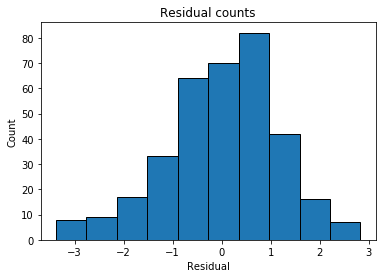

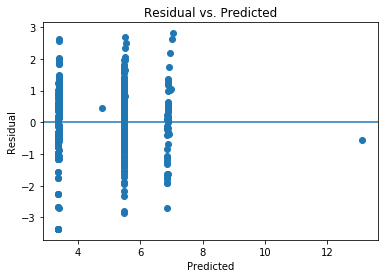

,Population,Murder,Robbery
Population,1.000000,0.162309,0.064371
Murder,0.162309,1.000000,0.313271
Robbery,0.064371,0.313271,1.000000


In [34]:
linregfunc(X.drop('Population Squared', axis=1), bc_prop_crime)

## What if we try coding each input as a binary (like the murder and robery from the original features) and ran those against the boxcox

In [43]:
binary_df = df.copy()
binary_df = binary_df.drop(['City', 'Population', 'Property crime'], axis=1).fillna(0)

for col in binary_df.columns:
    binary_df[col] = np.where(binary_df[col]==0,0,1)
binary_df['Population'] = df['Population']
binary_df['Property crime'] = df['Property crime']
binary_df['Population Squared'] = df['Population']**2
binary_df['BC Property crime'] = bc_prop_crime
#print(binary_df.head())

### Regression with all variables as binary against property crime 


Coefficients: 
 [ 4.41812162e-02  2.62149573e-01  7.43797186e-01  8.97838561e-01
  4.75751494e-01  1.18722719e+00  1.76757492e+00  5.44218456e-01
  2.51279661e-01  2.16745284e-05 -2.48590037e-12]

Intercept: 
 -0.09831131411934635

R-squared:
0.857151026342111


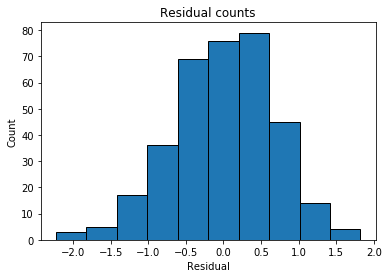

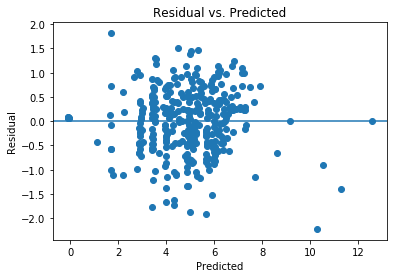

,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Population,Population Squared
Violent crime,1.000000,0.167753,0.348155,0.508127,0.856563,0.372693,0.345752,0.429117,0.177595,0.034255,0.022352
Murder and nonnegligent manslaughter,0.167753,1.000000,0.381186,0.313271,0.195844,0.102588,0.058001,0.225805,0.214409,0.162309,0.133067
Rape (legacy definition)2,0.348155,0.381186,1.000000,0.470749,0.302276,0.212913,0.120375,0.283244,0.268387,0.087335,0.064167
Robbery,0.508127,0.313271,0.470749,1.000000,0.428592,0.286105,0.175686,0.448838,0.203670,0.064371,0.043983
Aggravated assault,0.856563,0.195844,0.302276,0.428592,1.000000,0.339135,0.296159,0.403539,0.207334,0.039212,0.026094
Burglary,0.372693,0.102588,0.212913,0.286105,0.339135,1.000000,0.479420,0.337818,0.075278,0.021693,0.013670
Larceny- theft,0.345752,0.058001,0.120375,0.175686,0.296159,0.479420,1.000000,0.237247,0.061404,0.012352,0.007729
Motor vehicle theft,0.429117,0.225805,0.283244,0.448838,0.403539,0.337818,0.237247,1.000000,0.169144,0.048463,0.032573
Arson3,0.177595,0.214409,0.268387,0.203670,0.207334,0.075278,0.061404,0.169144,1.000000,-0.006565,-0.022778
Population,0.034255,0.162309,0.087335,0.064371,0.039212,0.021693,0.012352,0.048463,-0.006565,1.000000,0.998264


In [44]:
linregfunc(binary_df.drop(['Property crime', 'BC Property crime'], axis=1), bc_prop_crime)

## Now let's use the statsmodel regression to find the most important features by p-value

In [45]:
linform1 = "Q('BC Property crime') ~ Population + Q('Population Squared') + Q('Violent crime')+Q('Murder and nonnegligent manslaughter')+Q('Rape (legacy definition)2')+Robbery+Q('Aggravated assault')+Burglary+Q('Larceny- theft')+Q('Motor vehicle theft')+Arson3"
lm = smf.ols(formula=linform1, data=binary_df).fit()
print(lm.summary())

                              OLS Regression Results                              
Dep. Variable:     Q('BC Property crime')   R-squared:                       0.857
Model:                                OLS   Adj. R-squared:                  0.852
Method:                     Least Squares   F-statistic:                     183.3
Date:                    Sun, 14 Oct 2018   Prob (F-statistic):          1.11e-134
Time:                            14:38:27   Log-Likelihood:                -353.22
No. Observations:                     348   AIC:                             730.4
Df Residuals:                         336   BIC:                             776.7
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

Violent crime is not a very good feature due to it's correlation with aggrevated assault, its p-value greater than .05, and its confidence interval containing 0.  Also population is slightly better than population squared based on p-values.


Coefficients: 
 [ 2.60174916e-01  7.45740110e-01  9.02649353e-01  5.05533993e-01
  1.18880327e+00  1.77606640e+00  5.45582543e-01  2.50464111e-01
  2.16546381e-05 -2.48345788e-12]

Intercept: 
 -0.09852965464507335

R-squared:
0.8571331615008795


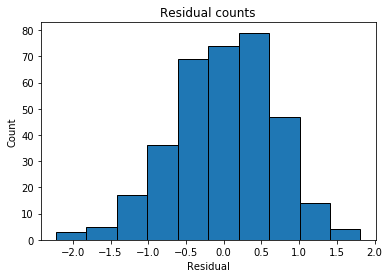

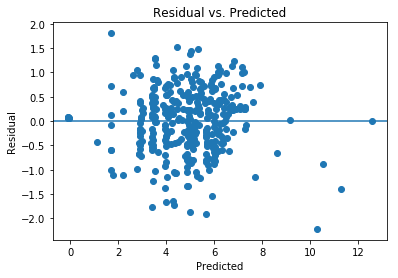

,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Population,Population Squared
Murder and nonnegligent manslaughter,1.000000,0.381186,0.313271,0.195844,0.102588,0.058001,0.225805,0.214409,0.162309,0.133067
Rape (legacy definition)2,0.381186,1.000000,0.470749,0.302276,0.212913,0.120375,0.283244,0.268387,0.087335,0.064167
Robbery,0.313271,0.470749,1.000000,0.428592,0.286105,0.175686,0.448838,0.203670,0.064371,0.043983
Aggravated assault,0.195844,0.302276,0.428592,1.000000,0.339135,0.296159,0.403539,0.207334,0.039212,0.026094
Burglary,0.102588,0.212913,0.286105,0.339135,1.000000,0.479420,0.337818,0.075278,0.021693,0.013670
Larceny- theft,0.058001,0.120375,0.175686,0.296159,0.479420,1.000000,0.237247,0.061404,0.012352,0.007729
Motor vehicle theft,0.225805,0.283244,0.448838,0.403539,0.337818,0.237247,1.000000,0.169144,0.048463,0.032573
Arson3,0.214409,0.268387,0.203670,0.207334,0.075278,0.061404,0.169144,1.000000,-0.006565,-0.022778
Population,0.162309,0.087335,0.064371,0.039212,0.021693,0.012352,0.048463,-0.006565,1.000000,0.998264
Population Squared,0.133067,0.064167,0.043983,0.026094,0.013670,0.007729,0.032573,-0.022778,0.998264,1.000000


In [46]:
linregfunc(binary_df.drop(['Property crime', 'BC Property crime', 'Violent crime'], axis=1), bc_prop_crime)


Coefficients: 
 [8.48892351e-01 9.18111135e-01 1.01352490e+00 5.17360147e-01
 1.19899871e+00 1.74244818e+00 6.42704308e-01 4.32377105e-01
 7.34590937e-07]

Intercept: 
 -0.0728851777328785

R-squared:
0.7919049775068665


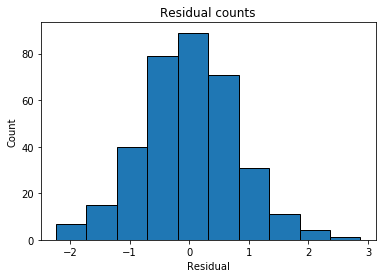

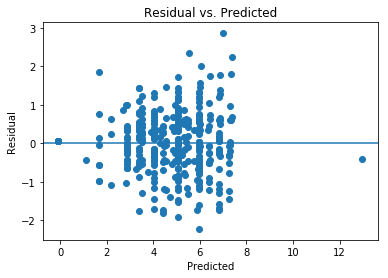

,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Population
Murder and nonnegligent manslaughter,1.000000,0.381186,0.313271,0.195844,0.102588,0.058001,0.225805,0.214409,0.162309
Rape (legacy definition)2,0.381186,1.000000,0.470749,0.302276,0.212913,0.120375,0.283244,0.268387,0.087335
Robbery,0.313271,0.470749,1.000000,0.428592,0.286105,0.175686,0.448838,0.203670,0.064371
Aggravated assault,0.195844,0.302276,0.428592,1.000000,0.339135,0.296159,0.403539,0.207334,0.039212
Burglary,0.102588,0.212913,0.286105,0.339135,1.000000,0.479420,0.337818,0.075278,0.021693
Larceny- theft,0.058001,0.120375,0.175686,0.296159,0.479420,1.000000,0.237247,0.061404,0.012352
Motor vehicle theft,0.225805,0.283244,0.448838,0.403539,0.337818,0.237247,1.000000,0.169144,0.048463
Arson3,0.214409,0.268387,0.203670,0.207334,0.075278,0.061404,0.169144,1.000000,-0.006565
Population,0.162309,0.087335,0.064371,0.039212,0.021693,0.012352,0.048463,-0.006565,1.000000


In [47]:
linregfunc(binary_df.drop(['Property crime', 'BC Property crime', 'Violent crime', 'Population Squared'], axis=1), bc_prop_crime)

In [48]:
linform2 = "Q('BC Property crime') ~ Population +Q('Murder and nonnegligent manslaughter')+Q('Rape (legacy definition)2')+Robbery+Q('Aggravated assault')+Burglary+Q('Larceny- theft')+Q('Motor vehicle theft')+Arson3"
lm = smf.ols(formula=linform2, data=binary_df).fit()
print(lm.summary())

                              OLS Regression Results                              
Dep. Variable:     Q('BC Property crime')   R-squared:                       0.792
Model:                                OLS   Adj. R-squared:                  0.786
Method:                     Least Squares   F-statistic:                     142.9
Date:                    Sun, 14 Oct 2018   Prob (F-statistic):          1.53e-109
Time:                            14:45:08   Log-Likelihood:                -418.68
No. Observations:                     348   AIC:                             857.4
Df Residuals:                         338   BIC:                             895.9
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

#### Let's now try using only the top 6 variables (the variables with t-stats greater than 5)

Motor vehicle, burglary, robbery, rape, murder, population


Coefficients: 
 [9.09900752e-01 1.01083437e+00 1.13595893e+00 1.80442429e+00
 8.08590865e-01 7.16720762e-07]

Intercept: 
 1.3106269908114214

R-squared:
0.7552266472398894


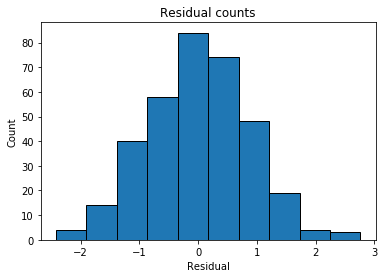

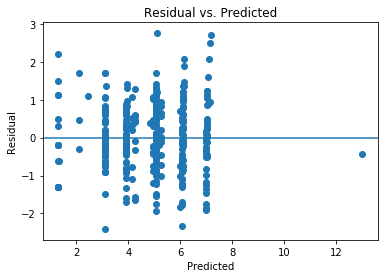

,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Burglary,Motor vehicle theft,Population
Murder and nonnegligent manslaughter,1.000000,0.381186,0.313271,0.102588,0.225805,0.162309
Rape (legacy definition)2,0.381186,1.000000,0.470749,0.212913,0.283244,0.087335
Robbery,0.313271,0.470749,1.000000,0.286105,0.448838,0.064371
Burglary,0.102588,0.212913,0.286105,1.000000,0.337818,0.021693
Motor vehicle theft,0.225805,0.283244,0.448838,0.337818,1.000000,0.048463
Population,0.162309,0.087335,0.064371,0.021693,0.048463,1.000000


In [49]:
linregfunc(binary_df.drop(['Property crime', 'BC Property crime', 'Violent crime', 'Population Squared', 'Aggravated assault', 'Larceny- theft', 'Arson3'], axis=1), bc_prop_crime)

In [50]:
linform3 = "Q('BC Property crime') ~ Population +Q('Murder and nonnegligent manslaughter')+Q('Rape (legacy definition)2')+Robbery+Burglary+Q('Motor vehicle theft')"
lm = smf.ols(formula=linform3, data=binary_df).fit()
print(lm.summary())

                              OLS Regression Results                              
Dep. Variable:     Q('BC Property crime')   R-squared:                       0.755
Model:                                OLS   Adj. R-squared:                  0.751
Method:                     Least Squares   F-statistic:                     175.4
Date:                    Sun, 14 Oct 2018   Prob (F-statistic):          5.15e-101
Time:                            14:52:54   Log-Likelihood:                -446.93
No. Observations:                     348   AIC:                             907.9
Df Residuals:                         341   BIC:                             934.8
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

# Validation on new model

### Holdout 20%

In [62]:
# Split the dataset 80/20
X_train, X_test, y_train, y_test = train_test_split(binary_df.drop(['Property crime', 'BC Property crime', 'Violent crime', 'Population Squared', 'Aggravated assault', 'Larceny- theft', 'Arson3'], axis=1), bc_prop_crime, test_size=0.2,random_state=42)

# Instantiate the model
regr = linear_model.LinearRegression()

# Fit the data
regr.fit(X_train, y_train)

# Coefficients and Intercept
print('Coefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)

# R squared
print('\nR-squared:')
print(regr.score(X_test, y_test))

Coefficients: 
 [1.00830693e+00 9.25326377e-01 1.22283040e+00 1.95085599e+00
 6.50829790e-01 7.04670731e-07]

Intercept: 
 1.2544884725730965

R-squared:
0.7120666228994815


### Cross validation

In [66]:
cross_val_score(regr, binary_df.drop(['Property crime', 'BC Property crime', 'Violent crime', 'Population Squared', 'Aggravated assault', 'Larceny- theft', 'Arson3'], axis=1), bc_prop_crime, cv=10)

array([   0.78820654,    0.69007797,    0.67410545,    0.71393782,
          0.62051444,    0.76626565, -211.05595319,    0.67871185,
          0.72376292,    0.76522196])

Something went wrong here.  Need to figure that out.

## Check with CO an GA

In [121]:
def testreg_new(df):
    binary_df=pd.DataFrame()
    depvar = df['Property crime']
    binary_df['Population'] = df["Population"]
    # Grab only the variables for modeling
    df = df.loc[:,['Murder and nonnegligent manslaughter', 'Rape (legacy definition)2', 'Robbery', 'Burglary', 'Motor vehicle theft']].dropna(axis=1)
    
    # make binary columns
    for col in df.columns:
        binary_df[col] = np.where(df[col]==0,0,1)
   
    # make all positive
    pos_prop_crime1 = depvar+1
    
    # boxcox transform
    bc_prop_crime1, lam = boxcox(pos_prop_crime1)

    X = binary_df
    Y = bc_prop_crime1
 
    linregfunc(X, Y)
    print(cross_val_score(regr, X, Y, cv=10))


Coefficients: 
 [7.91551249e-06 8.76258560e-01 1.36007681e+00 1.98591157e+00
 1.11408595e+00]

Intercept: 
 0.7814333963298559

R-squared:
0.7758770876854435


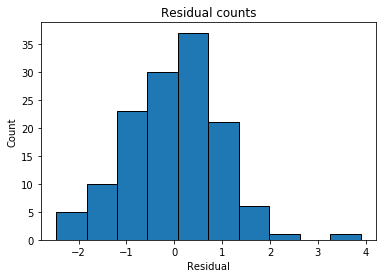

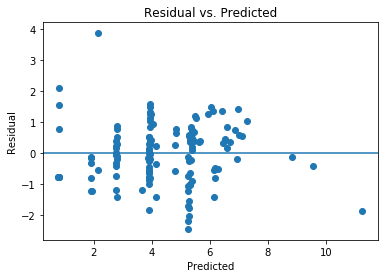

,Population,Murder and nonnegligent manslaughter,Robbery,Burglary,Motor vehicle theft
Population,1.000000,0.460498,0.321960,0.124719,0.182440
Murder and nonnegligent manslaughter,0.460498,1.000000,0.293684,0.172000,0.210101
Robbery,0.321960,0.293684,1.000000,0.259945,0.347422
Burglary,0.124719,0.172000,0.259945,1.000000,0.343749
Motor vehicle theft,0.182440,0.210101,0.347422,0.343749,1.000000


[0.77146617 0.95179232 0.53176121 0.65661629 0.6831205  0.61819156
 0.76496462 0.68915118 0.79615683 0.72909795]


In [122]:
testreg_new(CO)


Coefficients: 
 [2.05742324e-05 9.15579312e-01 1.00847940e+00 1.68022413e+00
 2.10806271e+00 1.37077682e+00]

Intercept: 
 0.5915061881545194

R-squared:
0.8194065340226919


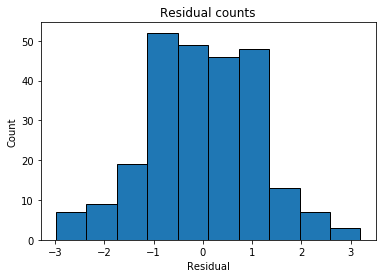

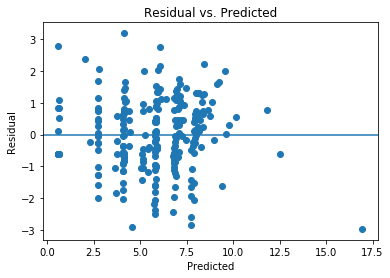

,Population,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Burglary,Motor vehicle theft
Population,1.000000,0.401951,0.300363,0.241191,0.095331,0.162132
Murder and nonnegligent manslaughter,0.401951,1.000000,0.462040,0.392479,0.121935,0.267049
Rape (legacy definition)2,0.300363,0.462040,1.000000,0.476146,0.258748,0.299066
Robbery,0.241191,0.392479,0.476146,1.000000,0.302193,0.469521
Burglary,0.095331,0.121935,0.258748,0.302193,1.000000,0.468026
Motor vehicle theft,0.162132,0.267049,0.299066,0.469521,0.468026,1.000000


[0.68571864 0.77146159 0.88671614 0.83154261 0.79725247 0.67781233
 0.83599744 0.87681116 0.75195877 0.77459477]


In [123]:
testreg_new(GA)

## Comments


The model seems to validate well for the 2 other states.  Need to figure out what happened with the cross validation on the original model.  

Method for linear regression in future.<br>
1) Check for normal distribution for dependent variable<br>
&emsp; a) if not normal - transform data appropriately to get normal (boxcox, etc.) <br>  
2) Check for linear relationships between dependent variable and feature variables<br>
&emsp; a) apply non-linear transform to create desired relationship<br>
&emsp; b) add supplemental variables based on what is found in the data<br>  
3) Run model and check residuals<br>
&emsp; a) Fix non-normal residual distribution - outliers and skewness in error can likely be fixed with fixing outliers and              skewness in data<br>  
4) Check homoscedasticity of residuals<br>  
5) Check for multicollinearity<br>
&emsp; a) Correlation is not as detrimental if we are creating a predictor model